In [2]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import random
import sys
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')
    
sess = tf.InteractiveSession()

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [3]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


In [18]:
# Copied pretty much directly from sklearn

# Returns a TensorFlow scalar with the size of the i-th dimension for
# the parameter tensor x.
def tf_get_shape(x, i):
    return tf.squeeze(tf.slice(tf.shape(x), [i], [1])) 

def tf_nrows(x):
    return tf_get_shape(x, 0)

def tf_ncols(x):
    return tf_get_shape(x, 1)

# Simultaneous K-cluster likelihood computation.
# X is NxD, mus is KxD, sigmas is KxD
# Output is KxN likelihoods for each sample in each cluster.
def tf_log_normals(X, mus, sigmas):
    # p(X) = sqrt(a * b * c)
    # a = (2 pi)^(-p)
    # b = det(sigma)^(-1)
    # c = exp(-(x - mu)^T sigma^(-1) (x - mu)) [expanded for numerical stability]
    #
    # Below we make simplifications since sigma is diag
    
    D = tf_ncols(mus)
    XT = tf.transpose(X) # pxN
    invsig = tf.inv(sigmas)
    
    loga = -tf.cast(D, 'float64') * tf.log(tf.constant(2 * np.pi, dtype='float64')) # scalar
    logb = tf.reduce_sum(tf.log(invsig), 1, keep_dims=True) # Kx1
    logc =  \
        - tf.reduce_sum(invsig * tf.square(mus), 1, keep_dims=True) \
        + 2 * tf.matmul(invsig * mus, XT) \
        - tf.matmul(invsig, tf.square(XT)) # KxN
    
    return 0.5 * (loga + logb + logc)

# Stably log-sum-exps likelihood along rows.
# Reduces KxN tensor L to 1xN tensor
def tf_log_sum_exp(L):
    maxs = tf.reduce_max(L, 0, keep_dims=True) # 1xN
    return tf.log(tf.reduce_sum(tf.exp(L - maxs), 0, keep_dims=True)) + maxs

# X is NxD, mus is KxD, sigmas KxD, alphas is K
# output is KxN log likelihoods.
def tf_log_likelihood(X, mus, sigmas, alphas):
    alphas = tf.expand_dims(alphas, 1) # Kx1
    return tf_log_normals(X, mus, sigmas) + tf.log(alphas) # KxN

# X is NxD, mus is KxD, sigmas KxD, alphas is K
# output is 1xN log probability for each sample, KxN responsibilities
def estep(X, mus, sigmas, alphas):
    log_likelihoods = tf_log_likelihood(X, mus, sigmas, alphas)
    sample_log_prob = tf_log_sum_exp(log_likelihoods) # 1xN
    return sample_log_prob, tf.exp(log_likelihoods - sample_log_prob)

EPS = np.finfo(float).eps
MIN_COVAR = EPS
# X is NxD, resp is KxN (and normalized along axis 0)
# Returns maximize step means, covariance, and cluster priors,
# which have dimension KxD, KxD, and K, respectively
def mstep(X, resp):
    weights = tf.reduce_sum(resp, 1) # K
    invweights = tf.expand_dims(tf.inv(weights + 10 * EPS), 1) # Kx1
    alphas = EPS + weights / (tf.reduce_sum(weights) + 10 * EPS) # K
    weighted_cluster_sum = tf.matmul(resp, X) # KxD 
    mus = weighted_cluster_sum * invweights
    avg_X2 = tf.matmul(resp, tf.square(X)) * invweights
    avg_mu2 = tf.square(mus)
    avg_X_mu = mus * weighted_cluster_sum * invweights
    sigmas = avg_X2 - 2 * avg_X_mu + avg_mu2 + MIN_COVAR
    # (x - mu) (x-mu)^T for banded. 
    return mus, sigmas, alphas

In [19]:
# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.82921532  0.74166541  0.91190172  0.83842359  0.69646833]
 [ 0.13678033  0.1481399   0.08065031  0.0659551   0.22347777]
 [ 0.03400434  0.1101947   0.00744797  0.09562131  0.0800539 ]]
log likelihoods    [[ 0.82921532  0.74166541  0.91190172  0.83842359  0.69646833]
 [ 0.13678033  0.1481399   0.08065031  0.0659551   0.22347777]
 [ 0.03400434  0.1101947   0.00744797  0.09562131  0.0800539 ]]
K=0 rmse=1.4895204919483638e-16
K=1 rmse=1.3738309013483032e-16
K=2 rmse=4.526431753179128e-17


In [21]:
# Similar pattern to
# https://gist.github.com/narphorium/d06b7ed234287e319f18

#todo try initializing covar to emprical cv computed from kmeans labels

# Runs up to max_steps EM iterations, stopping earlier if log likelihood improves
# less than tol.
# X should be an NxD data matrix, initial_mus should be KxD
# max_steps should be an int, tol should be a float.
def fit_em(X, initial_mus, max_steps, tol):
    N, D = X.shape
    K, Dmu = initial_mus.shape
    assert D == Dmu
        
    mus0 = initial_mus
    sigmas0 = np.tile(np.var(X, axis=0), (K, 1))
    alphas0 = np.ones(K) / K
    X = tf.constant(X)
    
    mus, sigmas, alphas = (tf.Variable(x, dtype='float64') for x in [mus0, sigmas0, alphas0])
    
    sess.run(tf.initialize_all_variables())
    all_ll, resp = estep(X, mus, sigmas, alphas)
    cmus, csigmas, calphas = mstep(X, resp)
    update_mus_step = tf.assign(mus, cmus)
    update_sigmas_step = tf.assign(sigmas, csigmas)
    update_alphas_step = tf.assign(alphas, calphas)     
    
    init_op = tf.initialize_all_variables()
    ll = prev_ll = -np.inf
                         
    with tf.Session() as sess2:
        sess2.run(init_op)
        for i in range(max_steps):
            ll = sess2.run(tf.reduce_mean(all_ll))
            sess2.run((update_mus_step, update_sigmas_step, update_alphas_step))
            print('EM iteration', i, 'log likelihood', ll)
            if abs(ll - prev_ll) < tol:
                break
            prev_ll = ll
        m, s, a = sess2.run((mus, sigmas, alphas))
    
    return ll, m, s, a

In [121]:
# Given a set of partial observations xs each of dimension O < D for a fitted GMM model with 
# K cluster priors alpha, KxD means mus, and KxD diagonal covariances sigmas,
# returns the weighted sum of normals for the remaining D - O dimensions.
#
# Returns posterior_mus, posterior_sigmas, posterior_prior,
# of dimensions:
# Kx(D-O), Kx(D-O), NxK, respectively (each mu, sigma is the same for all posteriors).
# NxK, NxKxD, NxKxD, respectively, for each x in xs, total of N.
def marginal_posterior(xs, mus, sigmas, alphas):
    # https://gbhqed.wordpress.com/2010/02/21/conditional-and-marginal-distributions-of-a-multivariate-gaussian/
    # diagonal case is easy:
    # https://en.wikipedia.org/wiki/Schur_complement#Applications_to_probability_theory_and_statistics
    O = xs.shape[1]
    D = mus.shape[1]
    observed_mus, observed_sigmas = (tf.constant(a, dtype='float64')
                                     for a in (mus[:,0:O], sigmas[:, 0:O]))
    ll = tf_log_likelihood(xs, observed_mus, observed_sigmas, alphas) # KxN
    norm = tf_log_sum_exp(ll) # 1xN
    ll, norm = sess.run((ll, norm))
    return mus[:, O:D], sigmas[:, O:D], np.transpose(ll / norm)

# A "sparser" estimate which just uses the most likely cluster's mean as the estimate.
def argmax_exp(mus, sigmas, alphas):
    i = np.argmax(alphas)
    return mus[i]

means
[[ 20.17616371  20.10495483]
 [  0.53687504   0.23774479]
 [ 10.42055163  10.07351857]]
cov
[[  1.46528671   1.06578162]
 [ 11.56134039   0.85248074]
 [  1.71172277  12.49839639]]
cluster priors
[ 0.33333333  0.34278281  0.32388386]


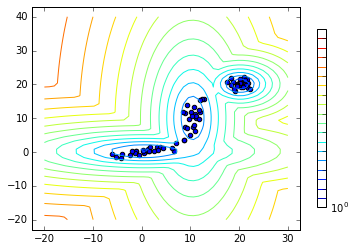

In [86]:
n_samples = 25
np.random.seed(0)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return np.dot(rs, shear.T) + shift
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[0., 3.5], [-0.7, .7]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3])
rx = np.random.choice(range(len(X)), 3, replace=False)

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
_, m, s, a = fit_em(X, X[rx], 100, EPS)
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T
ll = -estep(pts, m, s, a)[0].eval()
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

y = -10.0
y = 0.0
y = 2.5
y = 10.0
y = 20.0


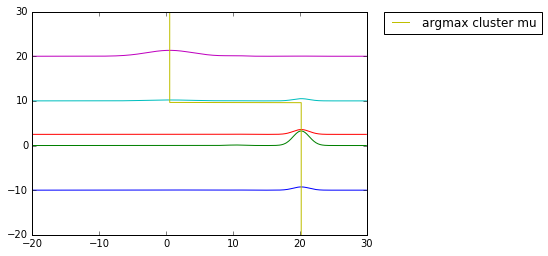

In [93]:
# Make this into a nice image.
ys = [-10, 0, 2.5, 10, 20]
pts = np.arange(-20, 30, 0.1, dtype='float64').reshape(-1, 1)
ys = np.array(ys, dtype='float64').reshape(-1, 1)
# Reverse m, s, a, since we know 'y'
mr, sr = (x[:, ::-1] for x in (m, s))
mm, sm, ams = marginal_posterior(ys, mr, sr, a)
for i, y in enumerate(ys.reshape(-1)):
    print('y =', y)
    ll = estep(pts, mm, sm, ams[i])[0].eval().reshape(-1)
    plt.plot(pts, np.exp(ll) / 10 + y)
    #plt.show()

ys = np.arange(-20, 30, 0.05, dtype='float64').reshape(-1, 1)
mm, sm, ams = marginal_posterior(ys, mr, sr, a)
xs = [argmax_exp(mm, sm, am) for am in ams]
plt.plot(xs, ys, label='argmax cluster mu')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [94]:
# N = 10
N = 33
p = 20 # D is better?
K = 6
k = 0 # maximum band offset (0 is just diagonal)
tissues_to_cluster = train_tissues
X_np = train_df_imp[train_tissues].values.transpose()

np.random.seed(2)
rc = np.random.choice(range(len(train_df)), D, replace=False)
rmu = np.random.choice(range(N), K, replace=False)

np.random.shuffle(X_np)
per = N // K
splits = [X_np[i:i+per] for i in range(0, N // K * K, per)]


# X_trunc = X_np[:N, rc]
X_trunc = X_np[:N]
mu_init = X_trunc[rmu]
# mu_init = np.array([x.mean(axis=0) for x in splits])
#mu_init = X_np[19:22]


print(mu_init.shape)

(6, 379551)


In [105]:
## Implement custom GMM
#todo check float32/float64 conversion for speedup
#todo scale (standardize) data before running
#todo kmeans warmup (just in numpy?)
#todo mincovar
lp, m, s, a = fit_em(X_trunc, mu_init, 100, EPS)
print('mean log likelihood\n{}\nmeans\n{}\ncov\n{}\ncluster priors\n{}'
      .format(lp, m, s, a))

mean log likelihood
633652.1419880254
means
[[ 0.87500975  0.90780635  0.92082692 ...,  0.89510721  0.83983662
   0.91930058]
 [ 0.619375    0.71688575  0.86936088 ...,  0.6439394   0.55386905
   0.81057038]
 [ 0.69037039  0.64749382  0.85318387 ...,  0.73382859  0.62189827
   0.8633888 ]
 [ 0.71669664  0.79454031  0.84682082 ...,  0.81952175  0.70167401
   0.865946  ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.58753563  0.67109878  0.77597403 ...,  0.65741036  0.56237251
   0.72967778]]
cov
[[  1.72977352e-02   7.67351835e-03   9.02567337e-04 ...,   5.74835123e-03
    8.74412279e-03   3.65791189e-03]
 [  9.87539063e-03   4.31950616e-03   1.49279891e-04 ...,   5.16530165e-04
    5.58044782e-03   4.48640346e-03]
 [  2.50644588e-03   6.09698901e-03   1.06965618e-03 ...,   2.38791375e-04
    3.45700023e-03   3.91929143e-03]
 [  1.88313334e-02   1.22776476e-02   7.54211056e-03 ...,   6.18999164e-03
    8.09318890e-03   3.99288546e-03]
 [  2.2204460

In [115]:
o = np.ones(len(train_df))
o[train_ix] = 0
o[test_ix] = 0
unobserved_untested_ix = np.where(o)[0]
o = np.zeros(len(train_df))
o[test_ix] = 1
unobserved_tested_ix = np.where(o)[0]

In [116]:
perm = np.hstack((train_ix, unobserved_tested_ix, unobserved_untested_ix))

In [117]:
observed = test_df['filled'][train_ix].values
len(perm), len(train_df)

(379551, 379551)

In [124]:
mm, ms = (x[:, perm] for x in (m, s))
print(len(mm[0]), len(ms[0]), len(a))
print(observed.reshape(1, len(observed)))
print(observed.shape)
mm, sm, ams = marginal_posterior(observed.reshape(1, len(observed)), mm, ms, a)
print(mm.shape, sm.shape, ams.shape)
pred = argmax_exp(mm, sm, ams[0])[:len(unobserved_tested_ix)]
print(pred)
actual = test_df['filled'][unobserved_tested_ix]
print(len(pred), len(actual))
print('rmse', math.sqrt(actual.sub(pred).pow(2).mean())) # rmse of GMM
print('r2', sklearn.metrics.r2_score(actual, pred))

379551 379551 6
[[ 0.6888889   0.8518519   0.14666666 ...,  0.877193    0.9259259
   0.41666666]]
(7523,)
(6, 372028) (6, 372028) (1, 6)
[ 0.87500975  0.90780635  0.92082692 ...,  0.89510721  0.83983662
  0.91930058]
368411 368411
rmse 0.07630200512736934
r2 0.796397458062
